# What neighborhood is best to walk in?

## Group name:
## **W** _on't_
## **A** _ctually_
## **L** _earn_
## **K** _oding_

# Introduction:
Walking is a very enjoyable activity. It gets you places, passes the time, and has various health benefits. Our group decided that the best Pittsburgh neighborhood is the one that best facilitates our feverish walking habits. You may ask, "What makes the best neighborhood to walk in?", "Is it scenery?". "Is it safety?". No and no. The best neighborhood was decided based on what requires the least effort, which was chosen based on the density of hills, and how annoying it is to drive in, which was chosen based on the prevalence of traffic lights and speed bumps. We chose these metrics because they provide a solid picture of the difficulty of walking in that area.

Here's a bit of rationale for each of our chosen datasets:
* **Hills:** Self explanatory; less hills means more walkability. In our analysis, we're working with the density of >25% slope. More on that later.
* **Traffic Lights:** Not only do more traffic lights mean more frustration for filthy car drivers, they allow for us walking enthusiasts to cross the street with minimal risk.
* **Speed Bumps:** Very similar line of reasoning here; more speed bumps == worse for cars. They also force cars to drive more slowly, which makes more densely speed-bumped areas less dangerous for walking.

# The Metrics:

Import stuff :)

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import geopandas as gpd
from tqdm import tqdm, notebook
import pickle

In [4]:
# dark mode better
plt.style.use('dark_background')

## Top 5 neighborhoods based on stoplight count:

Walking is wonderful, but every so often you come accross the asphalt harbinger of death and suffering that we know as a street. Unless you are an enthusiast of real life frogger, you, like esteemed the members of this group, find a light to cross the street at. Since lights make neighborhoods more navigable, we utilized a dataset that entered every red light and graphed the top 10 neighborhoods by stoplight count.

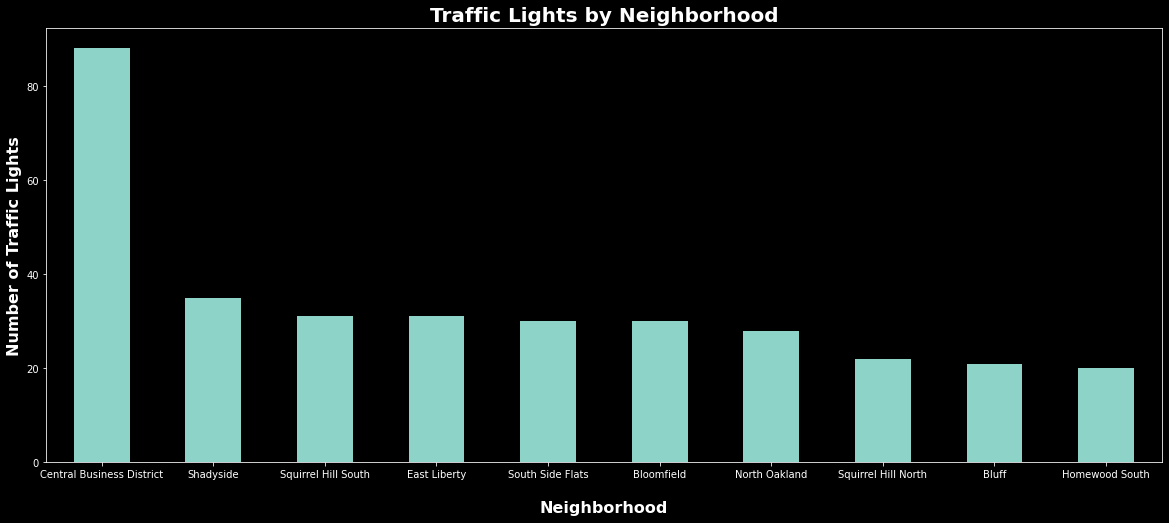

In [5]:
stopLights = pd.read_csv("RedLights.csv")    ##A file with a data entry for every traffic light in pittsburgh, and neighborhood its in
stopLights = stopLights["neighborhood"].value_counts().sort_values(ascending=False)

axprop = {'weight' : 'bold', 'fontsize' : 16}    #little input objects for formatting graphs
titleprop = {'weight' : 'bold', 'fontsize' : 20}
plot = stopLights.head(10).plot(kind='bar', rot=0, figsize = (20,8))
plot.set_xlabel("\nNeighborhood",axprop)  
plot.set_ylabel("Number of Traffic Lights",axprop)
plot.set_title('Traffic Lights by Neighborhood', titleprop)
plt.show()

## Top 5 Neighborhoods based on speed bump count:

Every driver is a maniac who envies our freedom to walk wherever we please, while they are confined to the road. Because of this envy, they want nothing more than to stick it to the walkers of the world by leaving behind nothing but a stain on the pavement for every encounter with a human not wrapped in a metal shell on wheels. At the very least, speed bumps slow these maniacs down, giving us free folk more time to get out of the road, and ideally, drivers hit these bumps far to fast, resulting in popped tires, and thus, greater safety for us all. For this dataset, which had an entry for every Pittsburgh speed bump, we graphed the top 10 neighborhoods by speed bump count.

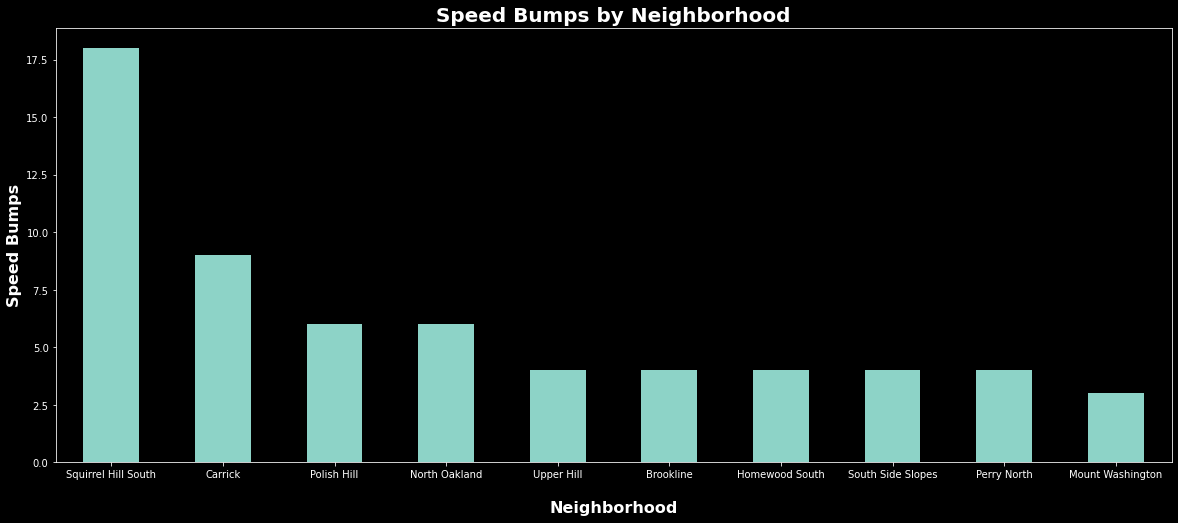

In [6]:
speedBumps = pd.read_csv("SpeedBumps.csv") # a file with every speed bump in pittsburgh and its neighborhood
speedBumps = speedBumps["neighborhood"].value_counts().sort_values(ascending=False)
plot = speedBumps.head(10).plot(kind='bar', rot=0, figsize = (20,8))

plot.set_xlabel("\nNeighborhood",axprop)
plot.set_ylabel("Speed Bumps",axprop)
plot.set_title('Speed Bumps by Neighborhood', titleprop)
plt.show()

## Top 5 Neighborhoods based on slope

### Importing the data
Read in the two shapefiles, then **EXPLODE** the slope dataframe  
<sub>Yes, explode, an actual pandas method, that takes every multipolygon and makes it however many rows of single polygons</sub>

In [5]:
slope = gpd.read_file('./25_Or_Greater_Slope/slope.shp')
hoods = gpd.read_file('./City_of_Pittsburgh_Neighborhoods/City_of_Pittsburgh_Neighborhoods.shp')

slope_exploded = slope.explode()

In [6]:
# objects to use as kwargs  
# this just cleans up some code later
tick_args={
    'left': False,
    'labelleft': False, 
    'labelbottom': False, 
    'bottom': False
}

Let's plot the shapefile.  
The blue areas correspond to places with a slope >25% (as in, every 100 feet you move forward, there's an elevation change of **at least** 25 feet).  
The data is effectively binary; this is not a representation of the exact slope value.  
If it's colored in, the slope is >25%. If it's not, the slope is <25%.

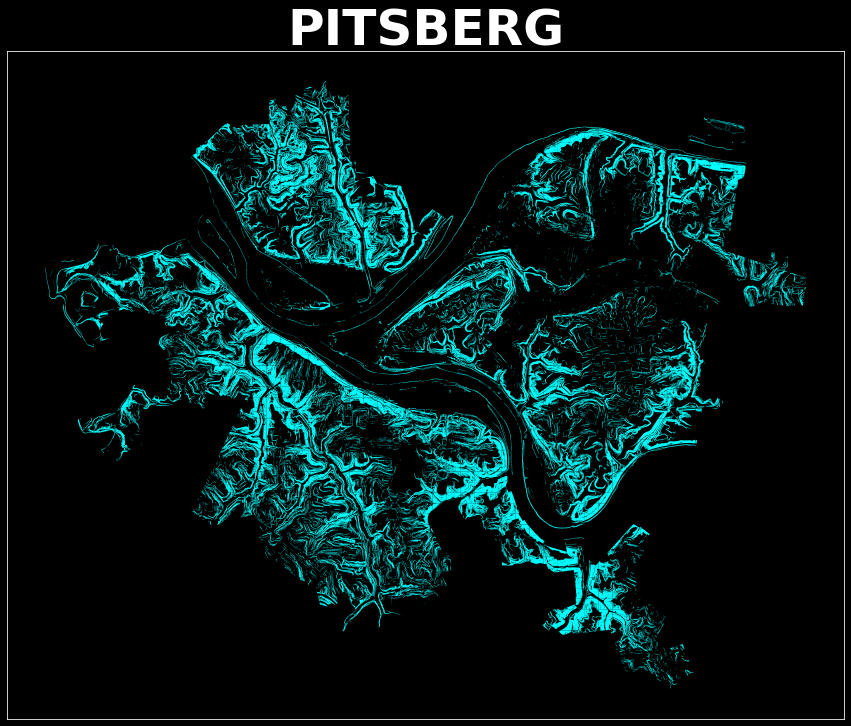

In [8]:
plot = slope.plot(
    color='cyan',
    figsize=(15,15)
)
plot.set_title('PITSBERG', weight='bold', fontsize=50)
plt.tick_params(**tick_args)
plt.show()

### Processing
Now, we:
* Create an array
* For every neighborhood...
    * For every slope geometry...
        * If the neighborhood geometry and the slope geometry intersect...
            * Add a dictionary to the array with the intersection and the index of the neighborhood
* Convert the array to a dataframe

The `.buffer(0)`'s after the geometries in the append are a bit of geopandas trickery.  
Trying to get the intersection of the hood and the slope throws an error about "invalid geometry".  
Typically `buffer()` creates a series of every geometry within a certain distance, and, for some reason, it also "validates" the geometry it's called on. So, calling it with a distance of 0 returns only the caller, but "valid".  
I've tested doing the buffer before the if statement, but not only does that make it take four hours, it seems that geometry validity only affects actually producing the intersection, but has no effect on checking whether they intersect.

In [9]:
data = []
pbar = tqdm(total=len(hoods) * len(slope_exploded))
for i1, hood in hoods.iterrows():
    for i2, s in slope_exploded.iterrows():
        if hood['geometry'].intersects(s['geometry']):
            data.append(
                {
                    'geometry': s['geometry'].buffer(0).intersection(hood['geometry'].buffer(0)),
                    'hood_i': i1
                })
        pbar.update(1)
df = gpd.GeoDataFrame(data, columns=['geometry', 'hood_i'])

100%|██████████| 3554915/3554915 [09:20<00:00, 4199.00it/s] 

Lets take a look at the new dataframe:

In [10]:
df.shape

(39530, 2)

In [11]:
df.head()

,geometry,hood_i
0,"POLYGON ((-79.95494 40.44103, -79.95502 40.441...",0
1,"POLYGON ((-79.95445 40.44102, -79.95454 40.441...",0
2,"POLYGON ((-79.95409 40.44058, -79.95424 40.440...",0
3,"POLYGON ((-79.95370 40.44059, -79.95370 40.440...",0
4,"POLYGON ((-79.95364 40.44124, -79.95364 40.441...",0


This is a plot of the slope shapefile, but separated by neighborhood.  
The colors have no meaning, they're purely a visual way to make each neighborhood distinct.

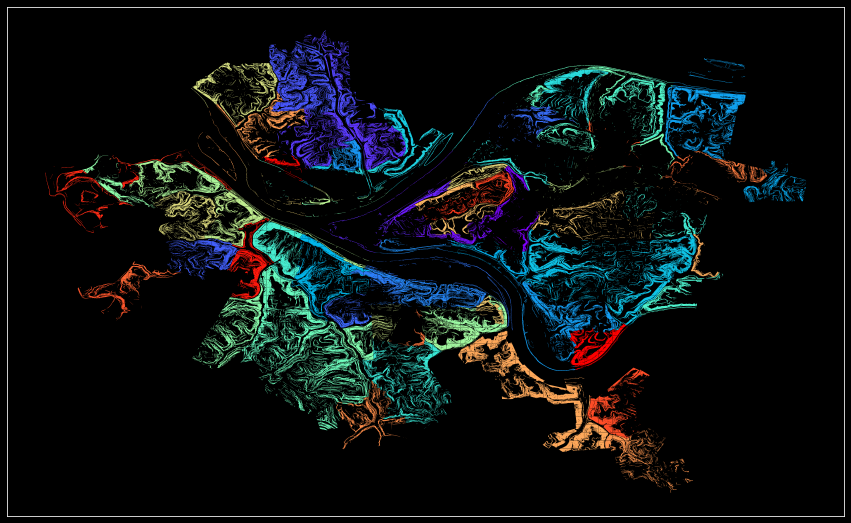

In [12]:
ax = df.plot(
    figsize=(15, 15), 
    column=df['hood_i'],
    cmap='rainbow',
)
plt.tick_params(**tick_args)
plt.show()

### Density
Now for the actual metric part, the density.  
Here's some more pseudocode for your glorious convenience:

* First, make a numpy array of 91 zeroes (an index for each neighborhood)
* For each row in the slope dataframe...
    * Add the area of the slope geometry to the index in the array corresponding to the neighborhood the slope geometry belongs to
* Initialize a new dictionary for the density dataframe, with a column for the neighborhood and a column for the density
* For each neighborhood...
    * Append the neighborhood to the 'name' column
    * Append the slope density (area of >25% slope / total neighborhood area) to the 'density' column
* Dataframe-ify the density dictionary

In [15]:
area = np.zeros(91)
for i, row in df.iterrows():
    area[row['hood_i']] += row['geometry'].area
d = {
    'name': [],
    'density': [],
}
for i, hood in hoods.iterrows():
    d['name'].append(hood['HOOD'])
    d['density'].append(area[i] / hood['geometry'].area)
density_df = pd.DataFrame(data=d)

Now that each neighborhood has a density, we can plot the neighborhoods shapefile and make the color correspond to the density: 

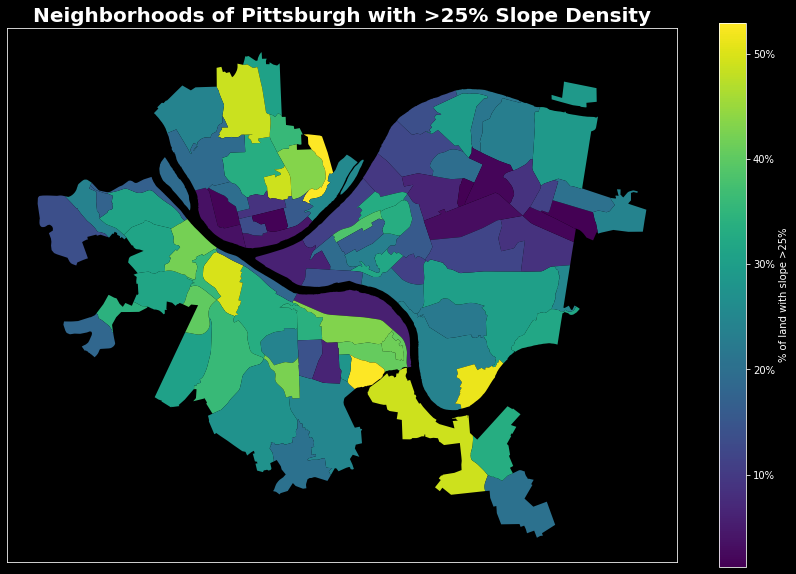

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
hoods.plot(
    ax=ax,
    column=density_df['density'],
    cmap='viridis',
    legend=True,
    legend_kwds={
        'label': "% of land with slope >25%",
        'orientation': 'vertical', 
        'format': mtick.PercentFormatter(1.0),
    },
)
plt.tick_params(**tick_args)
ax.set_title('Neighborhoods of Pittsburgh with >25% Slope Density', titleprop)
plt.show()

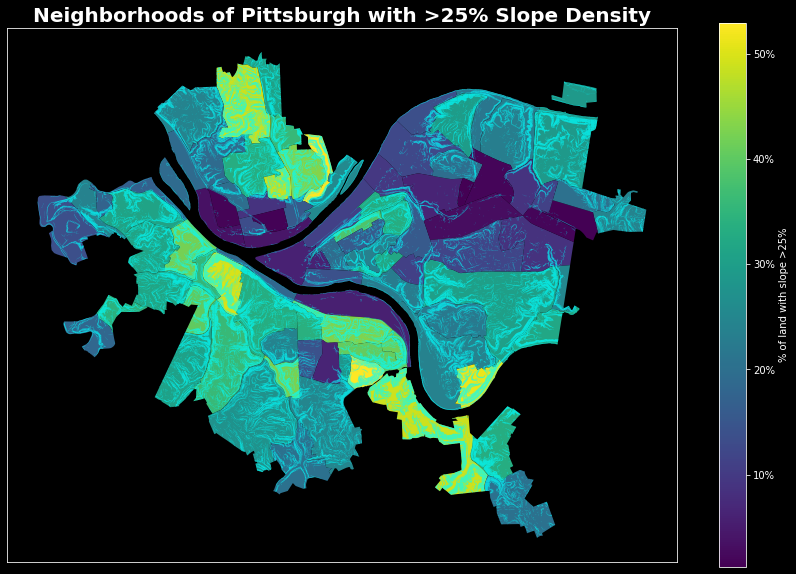

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
hoods.plot(
    ax=ax, 
    column=density_df['density'],
    cmap='viridis',
    legend=True,
    legend_kwds={
        'label': "% of land with slope >25%",
        'orientation': 'vertical', 
        'format': mtick.PercentFormatter(1.0),
    },
)
slope.plot(
    ax=ax,
    alpha=.7,
    color='cyan',
)
plt.tick_params(**tick_args)
ax.set_title('Neighborhoods of Pittsburgh with >25% Slope Density', titleprop)
plt.show()

This makes a dataframe with the top ten and bottom ten neighborhoods in terms of density, and plots them with a bit of styling :)

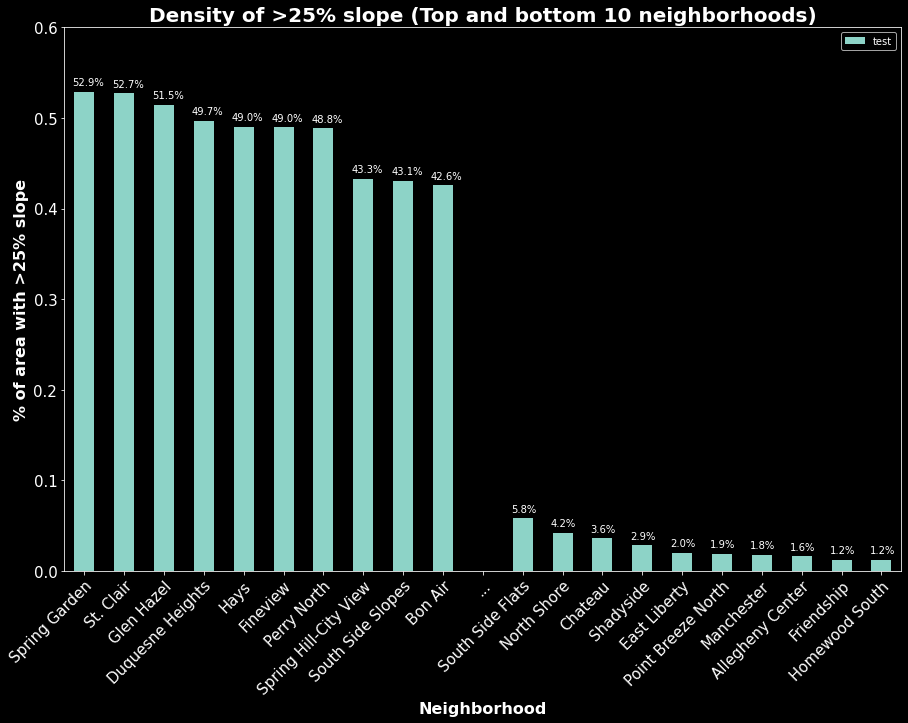

In [29]:
top_bottom_ten = pd.concat(
    (
        density_df.sort_values(by='density', ascending=False)[:10],
        pd.DataFrame({'name': ['...'], 'density': [0]}),
        density_df.sort_values(by='density', ascending=False)[-10:]
    ),
)
fig, ax = plt.subplots()
top_bottom_ten.plot.bar(
    ax=ax,
    x='name', 
    y='density', 
    label='test', 
    figsize=(15,10),
    ylim=(0, .6),
    fontsize=15
)
ax.set_title('Density of >25% slope (Top and bottom 10 neighborhoods)', titleprop)
ax.set_xlabel('Neighborhood', axprop)
ax.set_ylabel('% of area with >25% slope', axprop)
plt.setp(
    ax.xaxis.get_majorticklabels(), 
    rotation=45, 
    ha='right',
    rotation_mode='anchor',
)
for p in ax.patches:
    if p.get_height() != 0:
        ax.annotate(
            '{:.1%}'.format(p.get_height()), 
            (p.get_x() - .05, p.get_height() + .007),
        )

# Final Score:

Now to bring everything together!

This block makes a dataframe that contains each neighborhood, along with its density, # of speedbumps and # of stop lights.

In [30]:
speedBumps_df = pd.DataFrame(speedBumps)
final_data = []
for hood in hoods['HOOD']:
    final_data.append({
        'hood': hood,
        'density': density_df.query('name=="' + hood + '"')['density'].values[0],
        # The ternary operator is a beautiful thing
        'speedBumps': speedBumps[hood] if hood in speedBumps.keys() else 0,
        'stopLights': stopLights[hood] if hood in stopLights.keys() else 0,
    })
final_data_df = pd.DataFrame(final_data)

Now, we iterate through that dataframe and make a new one with each neighborhood's final score.  
The final score is calculated like so:

$\text{Score} = \frac{\text{Speed Bumps} + \text{Stop Lights}}{\text{Density} * 10}$

Since density is a value between 0 and 1, we mulitply it by 10 so that neighborhoods with a really low density don't have ridiculously high scores.

In [60]:
final_score = []
for i, row in final_data_df.iterrows():
    final_score.append({
        'hood': row['hood'],
        'score': (row['speedBumps'] + row['stopLights']) / (row['density'] * 10)
    })
final_score_df = pd.DataFrame(final_score)

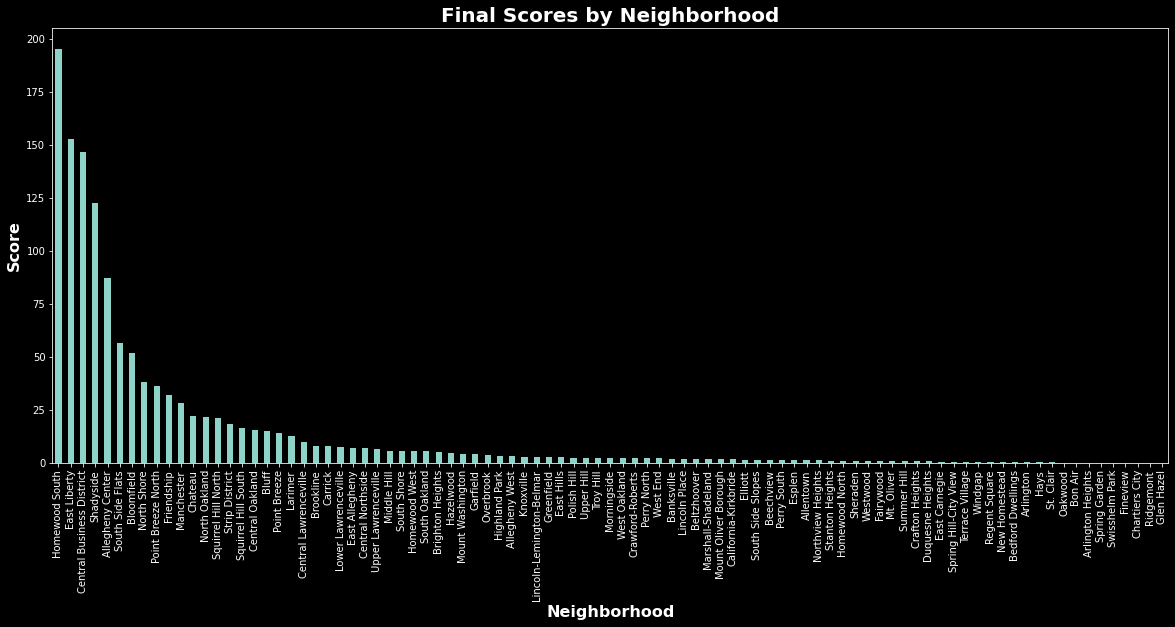

In [75]:
plot = final_score_df.sort_values(by='score', ascending=False).plot.bar(
    x='hood', 
    figsize=(20,8),
    legend=False,
)
plot.set_xlabel('Neighborhood', axprop)
plot.set_ylabel('Score', axprop)
plot.set_title('Final Scores by Neighborhood', titleprop)
plt.show()

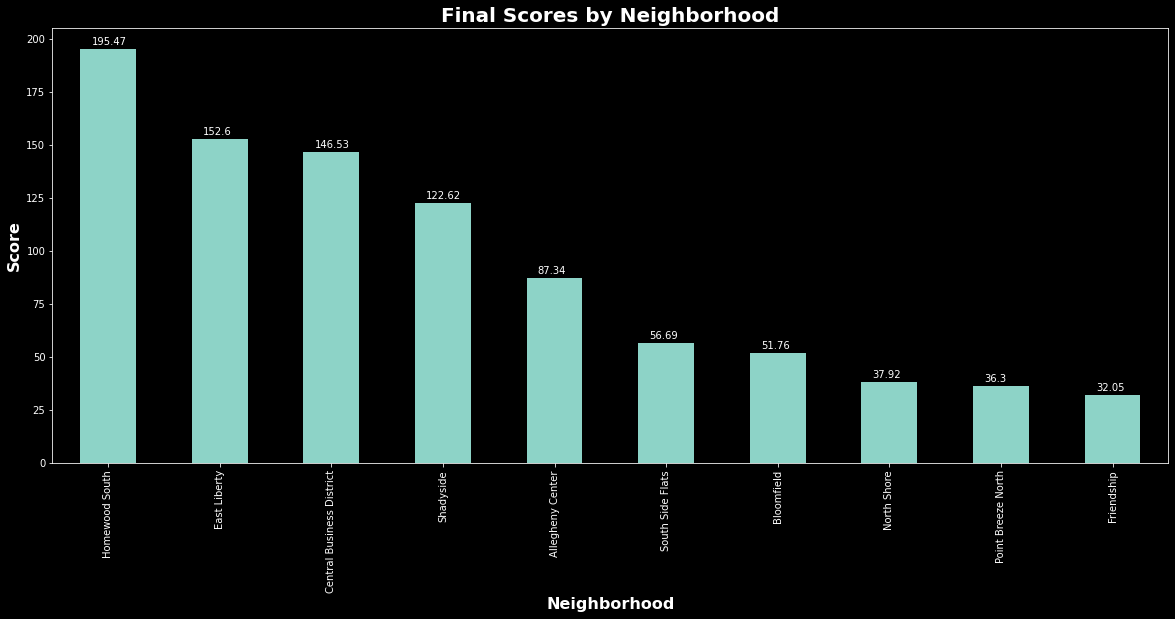

In [76]:
plot = final_score_df.sort_values(by='score', ascending=False).head(10).plot.bar(
    x='hood', 
    figsize=(20,8),
    legend=False,
)
plot.set_xlabel('Neighborhood', axprop)
plot.set_ylabel('Score', axprop)
plot.set_title('Final Scores by Neighborhood', titleprop)
for p in plot.patches:
    plot.annotate(
        p.get_height().round(2), 
        (p.get_x() + .1, p.get_height() + 2),
    )
plt.show()

# Conclusion: Congratulations Homewood South!

In compiling a supermetric that weighed all three metrics we chose to analyze, we discovered that Homewood south is _THE_ most walkable neighborhood in Pittsburgh, which is unsurprising considering it was the only neighborhood in the top 10 of every category.

# Our Opinions:

* Matthew: 
I have actually never seriously been to, like, any of the Pittsburgh neighborhoods, except for Downtown. Ironically, I've driven through basically all of them, and my only takeaways from that are that every road in Pittsburgh sucks, and that I hate the William Penn highway with a burning passion. I think I've destroyed more gas than the BP oil spill accelerating to 60 mph and then getting stopped and the red light 30 feet down the road.  
I guess to decide whether I agree with our data or not, I'd have to go check out Homewood South myself.  
Otherwise, I quite like the Central Business District for walking.

* Owen: I haven't been to most of the neighborhoods but my favorite neighborhood in Pittsburgh is actually South Oakland because it's where my friends and I all live and it's a good place to have fun. I have never been to Homewood South but I assume I would not like it because I don't like walking and as a driver, speed bumps and stoplights are a nuisance to me. Also, Homewood South seems to have nothing to do and I suspect that the stoplights and speed bumps placed there by the city of Pittsburgh are just a ploy to trap people in what may actually be Pittsburghs "boringest" neighborhood.  